



Epoch 1/160


283/283 [==============================] - ETA: 0s - loss: 16.3557 - mae: 16.0875
Epoch 1: val_loss improved from inf to 18.62119, saving model to age_model_weight644.h5
283/283 [==============================] - 14s 45ms/step - loss: 16.3557 - mae: 16.0875 - val_loss: 18.6212 - val_mae: 18.3743
Epoch 2/160
  2/283 [..............................] - ETA: 14s - loss: 14.6987 - mae: 14.4520

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


282/283 [============================>.] - ETA: 0s - loss: 14.8759 - mae: 14.6353
Epoch 2: val_loss improved from 18.62119 to 15.15922, saving model to age_model_weight644.h5
283/283 [==============================] - 12s 43ms/step - loss: 14.8750 - mae: 14.6344 - val_loss: 15.1592 - val_mae: 14.9239
Epoch 3/160
282/283 [============================>.] - ETA: 0s - loss: 14.5547 - mae: 14.3214
Epoch 3: val_loss did not improve from 15.15922
283/283 [==============================] - 12s 42ms/step - loss: 14.5550 - mae: 14.3217 - val_loss: 15.6463 - val_mae: 15.4153
Epoch 4/160
283/283 [==============================] - ETA: 0s - loss: 14.2744 - mae: 14.0453
Epoch 4: val_loss did not improve from 15.15922
283/283 [==============================] - 12s 42ms/step - loss: 14.2744 - mae: 14.0453 - val_loss: 15.9903 - val_mae: 15.7609
Epoch 5/160
282/283 [============================>.] - ETA: 0s - loss: 14.0538 - mae: 13.8207
Epoch 5: val_loss did not improve from 15.15922
283/283 [=========

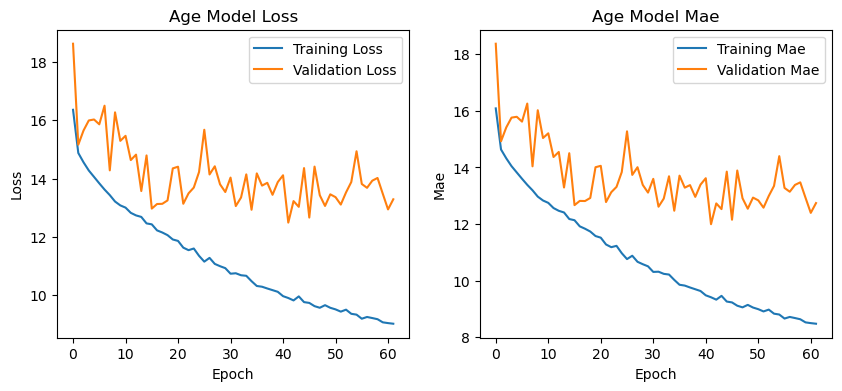

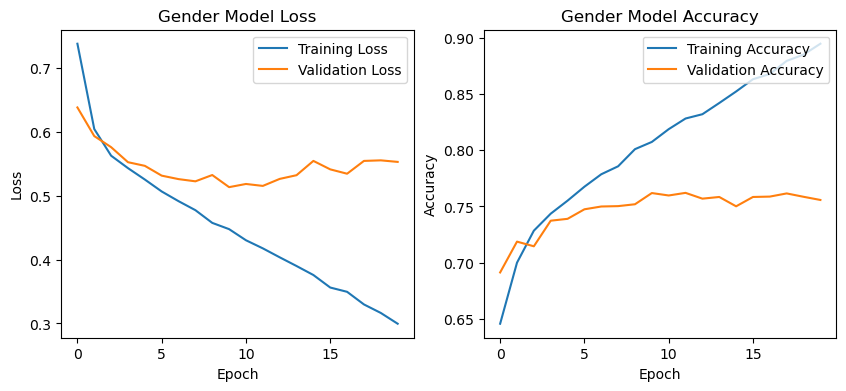

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, Flatten, Dense, MaxPooling2D, Conv2D, Input, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Veri setinin yolunu ayarlayın
data_folder = "C:/yas_tahmini/UTKFaceee"

# Veriyi yükle ve işle
files = os.listdir(data_folder)
ages = []
genders = []
images = []

for file in files:
    # Dosya adını '_' karakterine göre ayır ve uygun formatta olduğundan emin ol
    parts = file.split('_')
    if len(parts) < 3 or not parts[0].isdigit() or not parts[1].isdigit():
        continue

    age, gender = map(int, parts[:2])
    full_path = os.path.join(data_folder, file)
    image = cv2.imread(full_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (64, 64))
    images.append(image)
    ages.append(age)
    genders.append(gender)

# Listeleri NumPy dizilerine dönüştür
images_np = np.array(images) / 255  # Resimleri normalize et
ages_np = np.array(ages)
genders_np = np.array(genders)

# Veri kümesini eğitim ve test kümelerine ayır
X_train, X_test, Y_train, Y_test = train_test_split(images_np, list(zip(ages, genders)), test_size=0.25)
Y_train_2 = [np.array([y[1] for y in Y_train]), np.array([y[0] for y in Y_train])]
Y_test_2 = [np.array([y[1] for y in Y_test]), np.array([y[0] for y in Y_test])]

# CNN modelini tanımla
def Convolution(input_tensor, filters):
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.01))(input_tensor)
    x = Dropout(0.2)(x)
    x = Activation('relu')(x)
    return x

def age_model(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 32)
    maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
    conv_2 = Convolution(maxp_1, 32)
    maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
    flatten = Flatten()(maxp_2)
    dense_1 = Dense(64, activation='relu')(flatten)
    drop_1 = Dropout(0.2)(dense_1)
    output = Dense(1, activation="relu", name='age_output')(drop_1)
    model = Model(inputs=[inputs], outputs=[output])
    model.compile(loss=["mae"], optimizer="Adam", metrics=["mae"])
    return model

def gender_model(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 32)
    maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
    conv_2 = Convolution(maxp_1, 32)
    maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
    flatten = Flatten()(maxp_2)
    dense_1 = Dense(64, activation='relu')(flatten)
    drop_1 = Dropout(0.2)(dense_1)
    output = Dense(1, activation="sigmoid", name='gender_output')(drop_1)
    model = Model(inputs=[inputs], outputs=[output])
    model.compile(loss=["binary_crossentropy"], optimizer="Adam", metrics=["accuracy"])
    return model

# Modelleri Başlat
age_model = age_model((64, 64, 3))
gender_model = gender_model((64, 64, 3))

# Yas modeli için geri çağrılar
age_checkpoint = ModelCheckpoint('age_model_weight644.h5', monitor='val_loss', verbose=1, save_best_only=True)
age_early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)

# Cinsiyet modeli için geri çağrılar
gender_checkpoint = ModelCheckpoint('gender_model_weight644.h5', monitor='val_loss', verbose=1, save_best_only=True)
gender_early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# Yas modelini eğit
age_history = age_model.fit(
    X_train, Y_train_2[1], 
    batch_size=64, 
    validation_data=(X_test, Y_test_2[1]), 
    epochs=160, 
    callbacks=[age_checkpoint, age_early_stopping]
)

# Cinsiyet modelini eğit
gender_history = gender_model.fit(
    X_train, Y_train_2[0], 
    batch_size=64, 
    validation_data=(X_test, Y_test_2[0]), 
    epochs=160, 
    callbacks=[gender_checkpoint, gender_early_stopping]
)

# Erken Durdurma gerçekleştiği epok sayısını görüntüle
print(f"Age Model Early Stopping Epoch: {age_early_stopping.stopped_epoch}")
print(f"Gender Model Early Stopping Epoch: {gender_early_stopping.stopped_epoch}")

# Yas modelini değerlendir
age_model.evaluate(X_test, Y_test_2[1])

# Yas Modeli Kayıplarını Çiz
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(age_history.history['loss'], label='Training Loss')
plt.plot(age_history.history['val_loss'], label='Validation Loss')
plt.title('Age Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(age_history.history['mae'], label='Training Mae')
plt.plot(age_history.history['val_mae'], label='Validation Mae')
plt.title('Age Model Mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Cinsiyet Modeli Kayıplarını Çiz
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(gender_history.history['loss'], label='Training Loss')
plt.plot(gender_history.history['val_loss'], label='Validation Loss')
plt.title('Gender Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(gender_history.history['accuracy'], label='Training Accuracy')
plt.plot(gender_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Gender Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Eğitim sonrası model ağırlıklarını kaydet
age_model.save_weights('C:/Users/kasim.sahin/age_model_weight644.h5')
gender_model.save_weights('C:/Users/kasim.sahin/gender_model_weight644.h5')


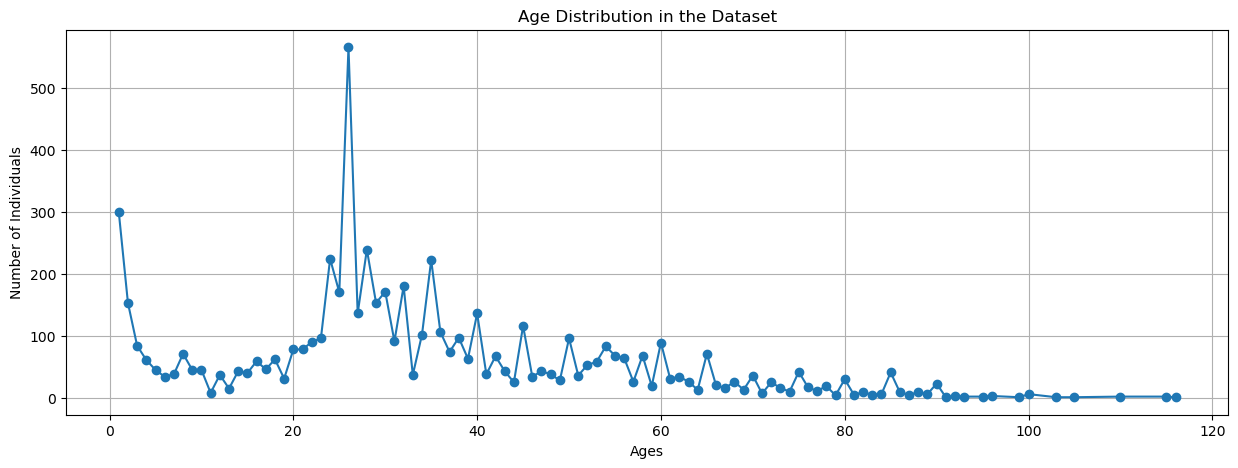

189/189 [==============================] - 1s 3ms/step
Mean Absolute Error (MAE) for Age Prediction: 11.99145962714516
Gender Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      3164
           1       0.77      0.71      0.74      2863

    accuracy                           0.76      6027
   macro avg       0.76      0.76      0.76      6027
weighted avg       0.76      0.76      0.76      6027



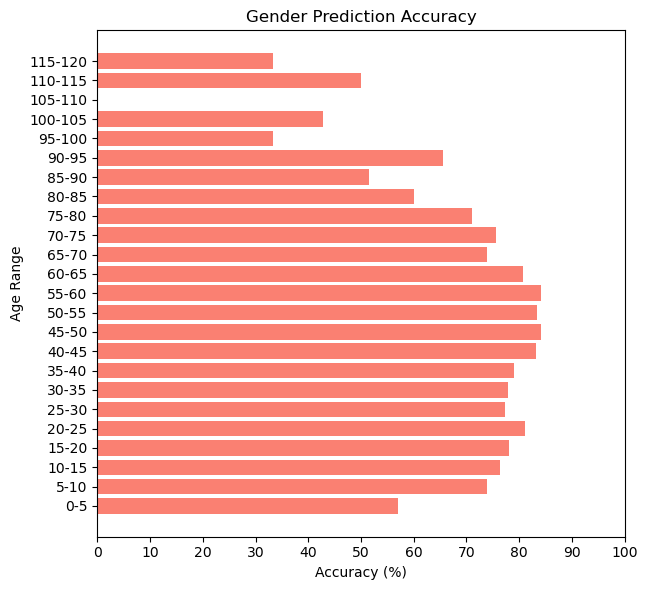

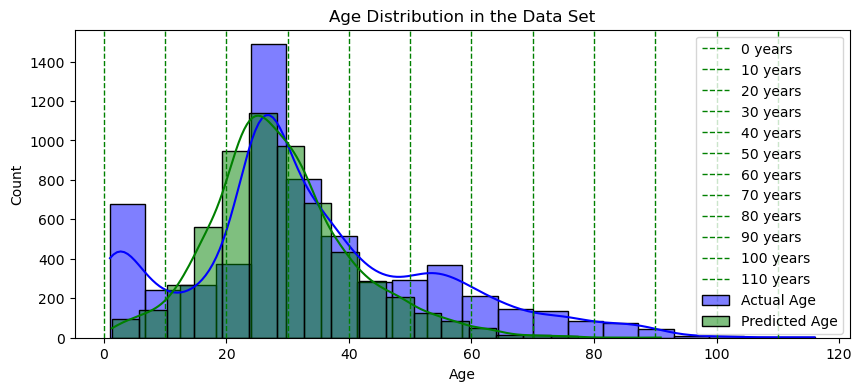

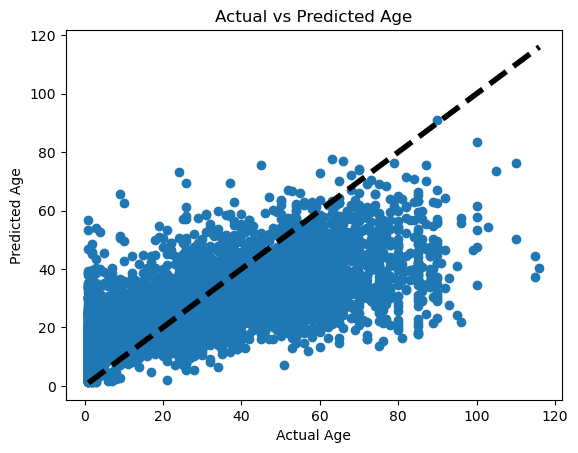

In [2]:
from sklearn.metrics import classification_report, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# Her yaş için kişi sayısını hesaplama
age_counts = {}
for age in Y_test_2[1]:
    if age in age_counts:
        age_counts[age] += 1
    else:
        age_counts[age] = 1

# Yaşlara göre dağılımı sıralı bir şekilde almak
sorted_ages = sorted(age_counts.keys())
counts = [age_counts[age] for age in sorted_ages]

# Yaş Dağılım Grafiği
plt.figure(figsize=(15, 5))
plt.plot(sorted_ages, counts, marker='o')
plt.xlabel('Ages')
plt.ylabel('Number of Individuals')
plt.title('Age Distribution in the Dataset')
plt.grid(True)
plt.show()


# Yaş doğruluk hesaplama fonksiyonu
def calculate_accuracies(ages, predictions):
    age_accuracies = {}
    for age in range(0, 120, 5):
        correct = 0
        total = 0
        for i in range(len(ages)):
            if age <= ages[i] < age + 5:
                total += 1
                if abs(predictions[i] - ages[i]) <= 5:
                    correct += 1
        if total > 0:
            accuracy = (correct / total) * 100
        else:
            accuracy = 0.0
        age_accuracies[f'{age}-{age + 5}'] = accuracy
    return age_accuracies

# Cinsiyet doğruluk hesaplama fonksiyonu
def calculate_gender_accuracies(ages, genders, predictions):
    gender_accuracies = {}
    for age in range(0, 120, 5):
        correct = 0
        total = 0
        for i in range(len(ages)):
            if age <= ages[i] < age + 5:
                total += 1
                if abs(predictions[i] - genders[i]) <= 0.5:
                    correct += 1
        if total > 0:
            accuracy = (correct / total) * 100
        else:
            accuracy = 0.0
        gender_accuracies[f'{age}-{age + 5}'] = accuracy
    return gender_accuracies

# Model ağırlıklarını yükleyin
age_model.load_weights('C:/Users/kasim.sahin/age_model_weight644.h5')
gender_model.load_weights('C:/Users/kasim.sahin/gender_model_weight644.h5')

# Yaş ve cinsiyet tahminlerini yap
y_pred_age = age_model.predict(X_test).flatten()
y_pred_gender = gender_model.predict(X_test)
y_pred_gender = (y_pred_gender > 0.5).astype(int)

# Doğruluk değerlerini ve MAE'yi hesapla
age_accuracies = calculate_accuracies(Y_test_2[1], y_pred_age)
gender_accuracies = calculate_gender_accuracies(Y_test_2[1], Y_test_2[0], y_pred_gender)
mae = mean_absolute_error(Y_test_2[1], y_pred_age)

# Doğruluk değerlerini ve MAE'yi hesapla
age_accuracies = calculate_accuracies(Y_test_2[1], y_pred_age)
gender_accuracies = calculate_gender_accuracies(Y_test_2[1], Y_test_2[0], y_pred_gender)
mae = mean_absolute_error(Y_test_2[1], y_pred_age)

# Doğruluk değerlerini ve sınıflandırma raporunu yazdır
print("Mean Absolute Error (MAE) for Age Prediction:", mae)
print("Gender Classification Report:")
print(classification_report(Y_test_2[0], y_pred_gender))

# Cinsiyet doğruluk değerlerini çiz
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
gender_ranges = list(gender_accuracies.keys())
accuracies_gender = list(gender_accuracies.values())
x_ticks = np.arange(0, 101, 10)  # 0'dan 100'e kadar 10 birimlik adımlarla bir dizi oluştur
plt.barh(gender_ranges, accuracies_gender, color='salmon')
plt.xticks(x_ticks)
plt.xlim(0, 100)
plt.xlabel('Accuracy (%)')
plt.ylabel('Age Range')
plt.title('Gender Prediction Accuracy')

plt.tight_layout()
plt.show()


# Veri Setindeki Yaş Dağılımı
plt.figure(figsize=(10, 4))
sns.histplot(Y_test_2[1], bins=20, color='blue', label='Actual Age', kde=True)
sns.histplot(y_pred_age, bins=20, color='green', label='Predicted Age', kde=True)
for age in range(0, 117, 10):
    plt.axvline(x=age, color='green', linestyle='--', linewidth=1, label=f'{age} years')
plt.title('Age Distribution in the Data Set')
plt.xlabel('Age')
plt.legend(loc='upper right')
plt.show()

# Yaş Tahminlerini Karşılaştırma Grafiği
fig, ax = plt.subplots()
ax.scatter(Y_test_2[1], y_pred_age)
ax.plot([Y_test_2[1].min(), Y_test_2[1].max()], [Y_test_2[1].min(), Y_test_2[1].max()], 'k--', lw=4)
ax.set_xlabel('Actual Age')
ax.set_ylabel('Predicted Age')
plt.title('Actual vs Predicted Age')
plt.show()


189/189 [==============================] - 1s 3ms/step
Accuracy within 3 years: 20.209059233449477%


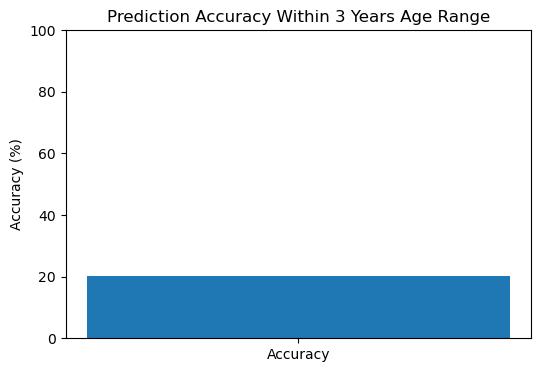

189/189 [==============================] - 1s 3ms/step
Age group 0-4: 10.367892976588628 accuracy
Age group 5-9: 12.875536480686694 accuracy
Age group 10-14: 14.864864864864865 accuracy
Age group 15-19: 23.949579831932773 accuracy
Age group 20-24: 38.69257950530035 accuracy
Age group 25-29: 35.62945368171022 accuracy
Age group 30-34: 27.022375215146297 accuracy
Age group 35-39: 19.395017793594306 accuracy
Age group 40-44: 12.944983818770226 accuracy
Age group 45-49: 8.880308880308881 accuracy
Age group 50-54: 7.05521472392638 accuracy
Age group 55-59: 5.3061224489795915 accuracy
Age group 60-64: 2.072538860103627 accuracy
Age group 65-69: 3.4246575342465753 accuracy
Age group 70-74: 2.127659574468085 accuracy
Age group 75-79: 1.0752688172043012 accuracy
Age group 80-84: 0.0 accuracy
Age group 85-89: 0.0 accuracy
Age group 90-94: 3.4482758620689653 accuracy
Age group 95-99: 0.0 accuracy
Age group 100-104: 0.0 accuracy
Age group 105-109: 0.0 accuracy
Age group 110-114: 0.0 accuracy
Age g

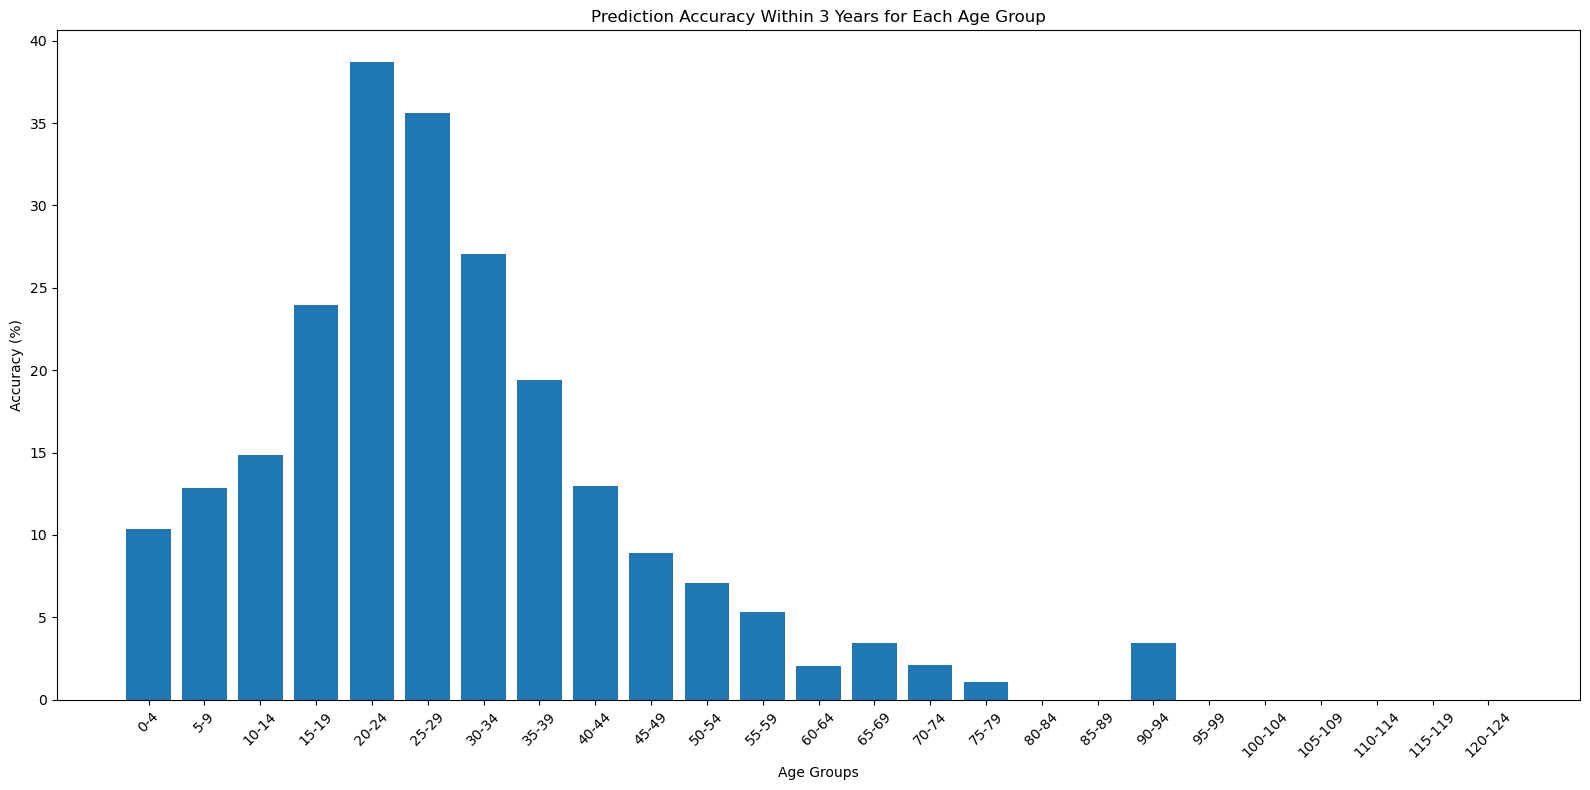

In [3]:

def calculate_accuracy_within_3_years(y_true, y_pred):
    correct = 0
    total = len(y_true)

    for actual_age, predicted_age in zip(y_true, y_pred):
        lower_bound = predicted_age - 3
        upper_bound = predicted_age + 3
        if lower_bound <= actual_age <= upper_bound:
            correct += 1

    accuracy = (correct / total) * 100
    return accuracy

# Age Model tahminleri
predicted_ages = age_model.predict(X_test).flatten()

# Tahminlerin doğruluğunu hesapla
accuracy_within_3_years = calculate_accuracy_within_3_years(Y_test_2[1], predicted_ages)

# Doğruluk oranını bas
print(f"Accuracy within 3 years: {accuracy_within_3_years}%")

# Doğruluk oranını gösteren grafik
plt.figure(figsize=(6, 4))
plt.bar(['Accuracy'], [accuracy_within_3_years])
plt.ylabel('Accuracy (%)')
plt.title('Prediction Accuracy Within 3 Years Age Range')
plt.ylim(0, 100)
plt.show()



# Eğitim sonrası model ağırlıklarını kaydet
#age_model.save_weights('C:/Users/kasim.sahin/age_model_weight644.h5')
#gender_model.save_weights('C:/Users/kasim.sahin/gender_model_weight644.h5')

# Yeni eklenen fonksiyon ve kodlar
def calculate_accuracy_within_3_years_per_age_group(y_true, y_pred, age_groups):
    # Her yaş grubu için doğruluk oranlarını saklayacak sözlük
    accuracy_per_group = {group: {'correct': 0, 'total': 0} for group in age_groups}

    for actual_age, predicted_age in zip(y_true, y_pred):
        # Hangi yaş grubuna ait olduğunu bul
        age_group = min([group for group in age_groups if actual_age in group], key=lambda g: (actual_age in g, -len(g)))

        # 3 yıllık aralıkta doğru mu kontrol et
        lower_bound = predicted_age - 3
        upper_bound = predicted_age + 3
        if lower_bound <= actual_age <= upper_bound:
            accuracy_per_group[age_group]['correct'] += 1
        accuracy_per_group[age_group]['total'] += 1

    # Her yaş grubu için yüzde doğruluk hesapla, 0'a bölme hatasını önle
    accuracy_percentages = {}
    for group, values in accuracy_per_group.items():
        if values['total'] > 0:
            accuracy = (values['correct'] / values['total']) * 100
        else:
            accuracy = 'N/A'  # Veri yok
        accuracy_percentages[group] = accuracy

    return accuracy_percentages

# Yaş gruplarını tanımla (0-120 arası 5'er yıllık dilimler)
age_groups = [range(i, i + 5) for i in range(0, 121, 5)]

# Age Model tahminleri
predicted_ages = age_model.predict(X_test).flatten()

# Gerçek yaş etiketlerini al (Y_test_2[1] test setindeki yaşları içerir)
Y_age_test = Y_test_2[1]

# Her yaş grubu için doğruluk oranını hesapla
accuracy_per_age_group = calculate_accuracy_within_3_years_per_age_group(Y_age_test, predicted_ages, age_groups)

# Sonuçları bas
for age_group, accuracy in accuracy_per_age_group.items():
    print(f"Age group {min(age_group)}-{max(age_group)}: {accuracy} accuracy")

# Sonuçları grafikte göster (N/A durumları hariç tut)
plt.figure(figsize=(16, 8))
plt.bar(range(len(accuracy_per_age_group)), [acc if isinstance(acc, float) else 0 for acc in accuracy_per_age_group.values()], align='center')
plt.xticks(range(len(accuracy_per_age_group)), [f"{min(group)}-{max(group)}" for group in age_groups], rotation=45)
plt.xlabel('Age Groups')
plt.ylabel('Accuracy (%)')
plt.title('Prediction Accuracy Within 3 Years for Each Age Group')
plt.tight_layout()  # Etiketlerin düzgün görünmesi için
plt.show()


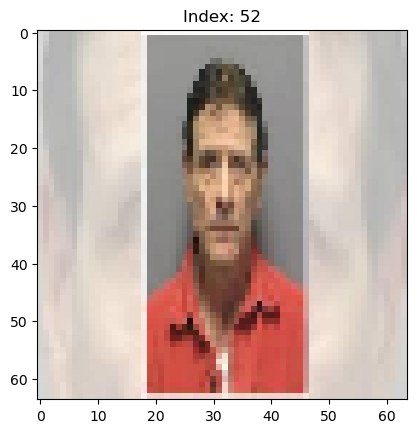

1/1 [==============================] - 0s 24ms/step
Actual Age: 58, Actual Gender: Male
Predicted Age: 17, Predicted Gender: Male


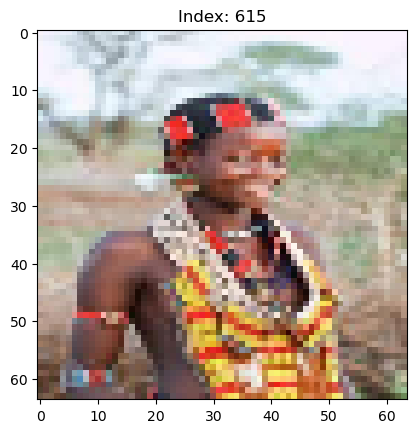

1/1 [==============================] - 0s 23ms/step
Actual Age: 26, Actual Gender: Female
Predicted Age: 24, Predicted Gender: Male


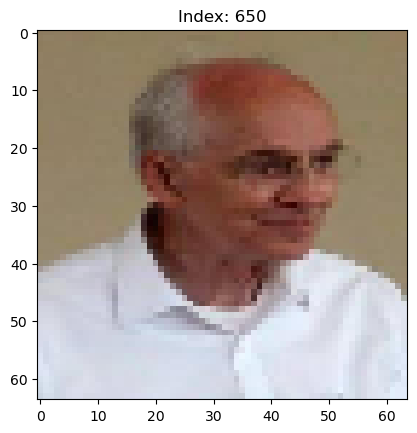

1/1 [==============================] - 0s 25ms/step
Actual Age: 75, Actual Gender: Male
Predicted Age: 35, Predicted Gender: Male


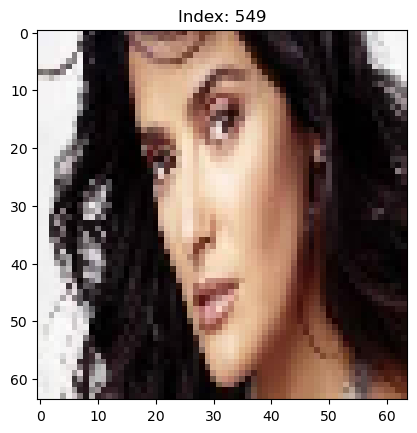

1/1 [==============================] - 0s 27ms/step
Actual Age: 26, Actual Gender: Female
Predicted Age: 18, Predicted Gender: Female


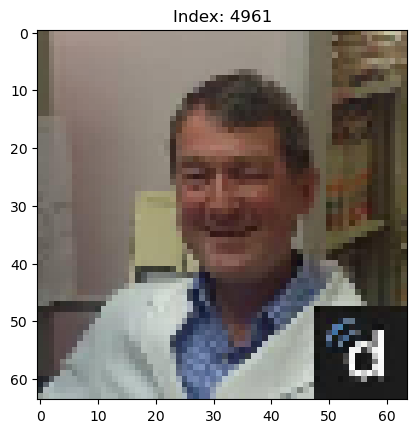

1/1 [==============================] - 0s 23ms/step
Actual Age: 56, Actual Gender: Male
Predicted Age: 33, Predicted Gender: Male


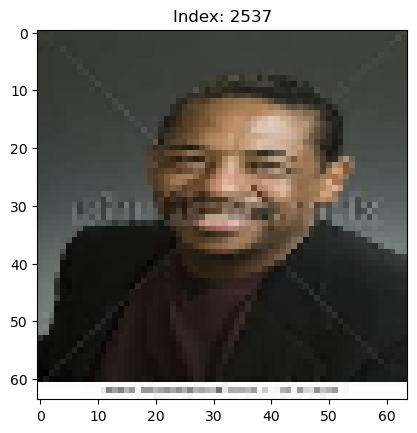

1/1 [==============================] - 0s 23ms/step
Actual Age: 60, Actual Gender: Male
Predicted Age: 42, Predicted Gender: Male


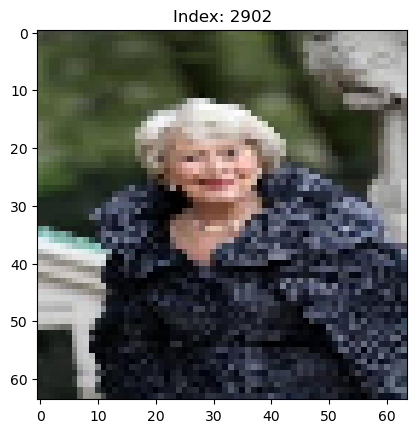

1/1 [==============================] - 0s 23ms/step
Actual Age: 61, Actual Gender: Female
Predicted Age: 33, Predicted Gender: Female


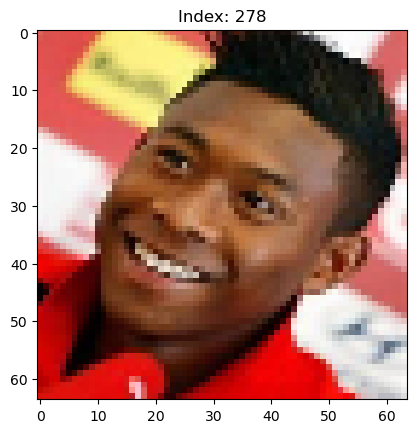

1/1 [==============================] - 0s 23ms/step
Actual Age: 28, Actual Gender: Male
Predicted Age: 29, Predicted Gender: Female


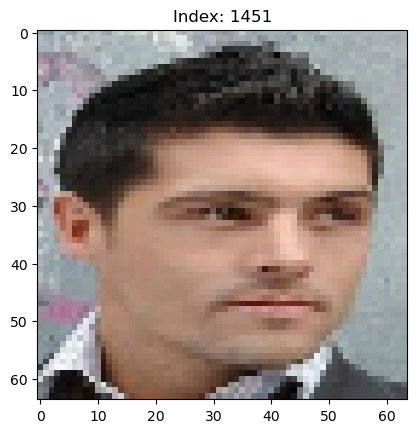

1/1 [==============================] - 0s 23ms/step
Actual Age: 22, Actual Gender: Male
Predicted Age: 22, Predicted Gender: Male


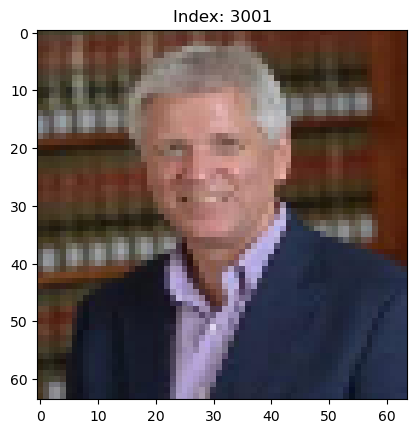

1/1 [==============================] - 0s 23ms/step
Actual Age: 58, Actual Gender: Male
Predicted Age: 50, Predicted Gender: Male


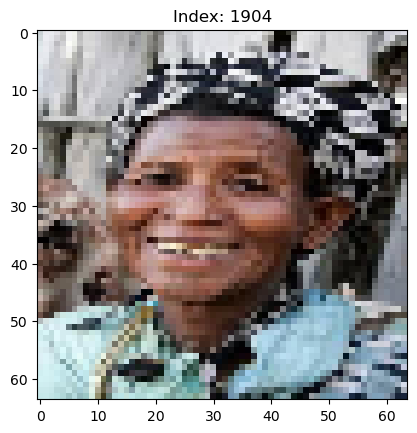

1/1 [==============================] - 0s 10ms/step
Actual Age: 61, Actual Gender: Female
Predicted Age: 29, Predicted Gender: Male


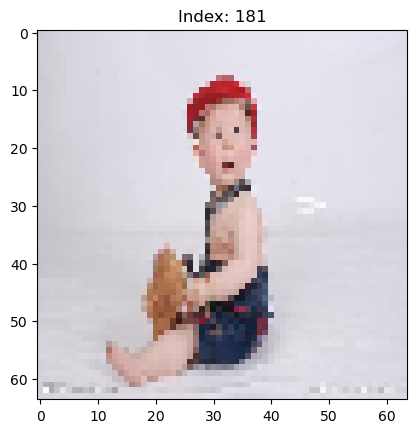

1/1 [==============================] - 0s 23ms/step
Actual Age: 2, Actual Gender: Male
Predicted Age: 8, Predicted Gender: Male


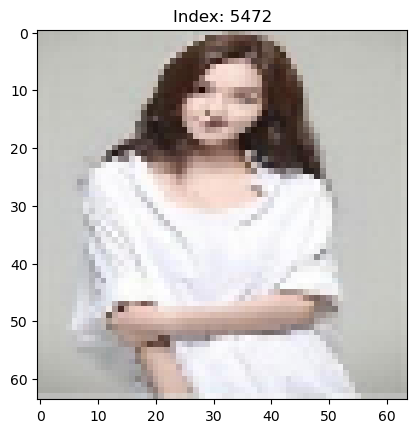

1/1 [==============================] - 0s 23ms/step
Actual Age: 26, Actual Gender: Female
Predicted Age: 22, Predicted Gender: Female


In [4]:
# Veri yükleme ve işleme adımlarınız burada olacak

def test_specific_images(indices, age_model, gender_model, X_test, Y_test):
    for index in indices:
        if 0 <= index < len(X_test):
            actual_age, actual_gender = Y_test[index][0], Y_test[index][1]
            actual_gender_str = 'Female' if actual_gender == 1 else 'Male'

            plt.imshow(X_test[index])
            plt.title(f"Index: {index}")
            plt.show()

            age_pred = age_model.predict(np.array([X_test[index]]))
            gender_pred = gender_model.predict(np.array([X_test[index]]))

            # Modelin çıktılarını tek boyutlu olarak ele al
            predicted_age = int(np.round(age_pred[0]))
            predicted_gender = 'Female' if int(np.round(gender_pred[0])) == 1 else 'Male'

            print(f"Actual Age: {actual_age}, Actual Gender: {actual_gender_str}")
            print(f"Predicted Age: {predicted_age}, Predicted Gender: {predicted_gender}")
        else:
            print(f"Index {index} is out of range. Valid range is 0 to {len(X_test) - 1}")

# Belirli indekslerde test işlemi gerçekleştir
specific_indices = [52, 615, 650, 549, 4961, 2537, 2902, 278, 1451, 3001, 1904, 181, 5472]
test_specific_images(specific_indices, age_model, gender_model, X_test, Y_test)


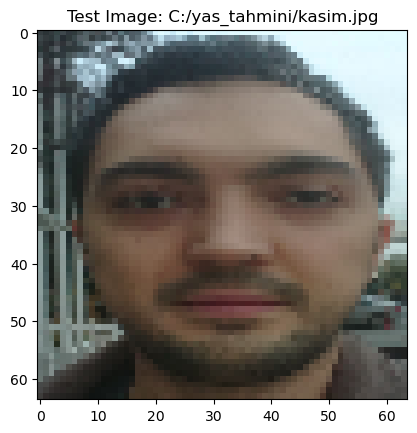

1/1 [==============================] - 0s 87ms/step
Predicted Age: 28, Predicted Gender: Male


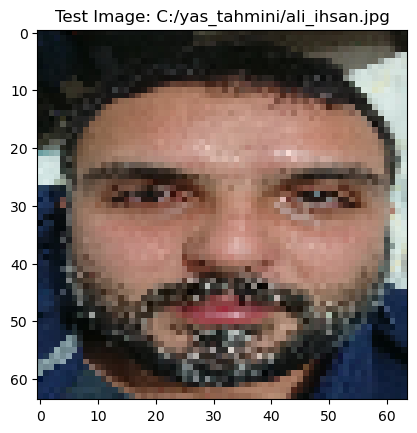

1/1 [==============================] - 0s 23ms/step
Predicted Age: 25, Predicted Gender: Male


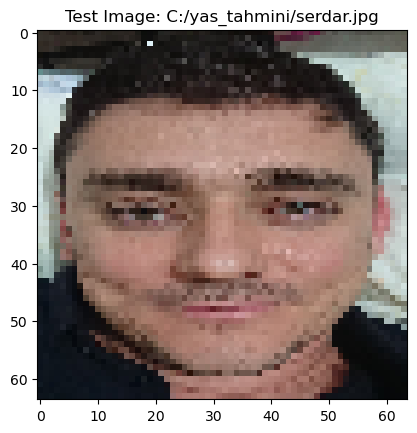

1/1 [==============================] - 0s 22ms/step
Predicted Age: 30, Predicted Gender: Male


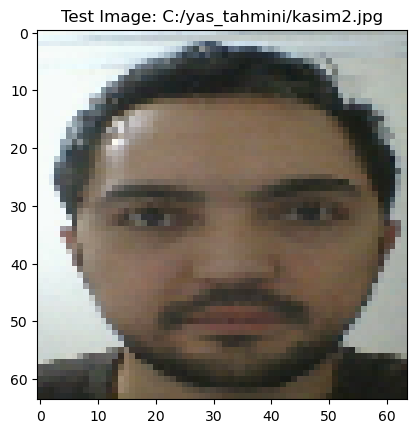

1/1 [==============================] - 0s 23ms/step
Predicted Age: 23, Predicted Gender: Male


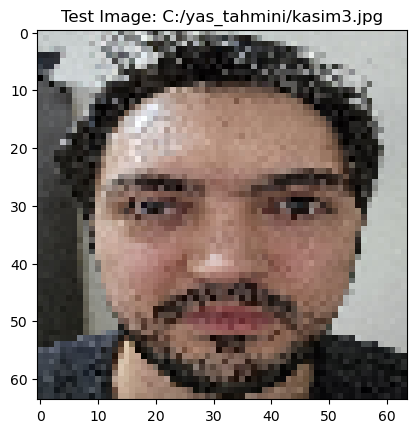

1/1 [==============================] - 0s 23ms/step
Predicted Age: 34, Predicted Gender: Male


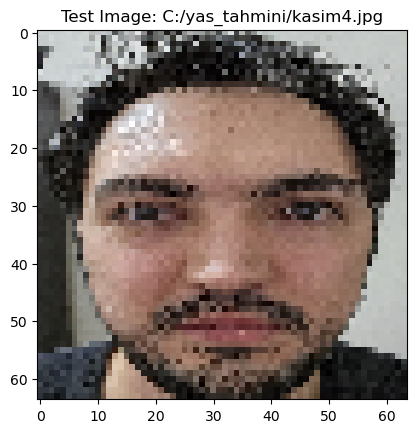

1/1 [==============================] - 0s 22ms/step
Predicted Age: 30, Predicted Gender: Female


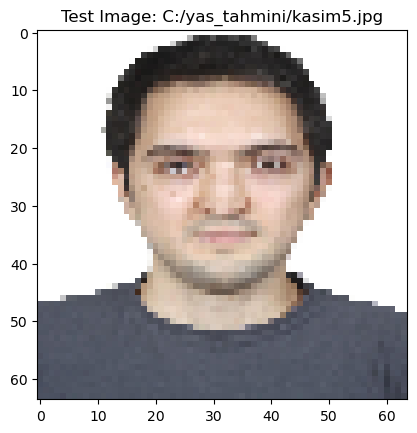

1/1 [==============================] - 0s 23ms/step
Predicted Age: 27, Predicted Gender: Male


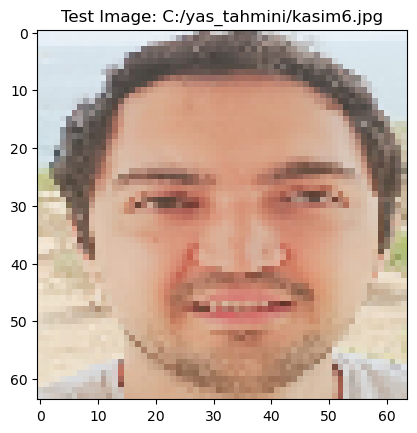

1/1 [==============================] - 0s 23ms/step
Predicted Age: 24, Predicted Gender: Male


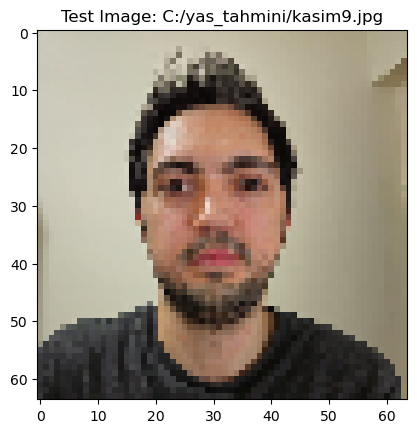

1/1 [==============================] - 0s 23ms/step
Predicted Age: 21, Predicted Gender: Male


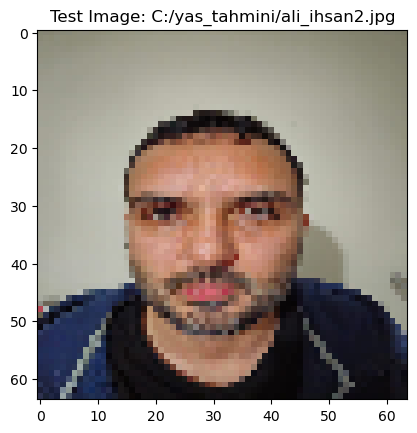

1/1 [==============================] - 0s 22ms/step
Predicted Age: 30, Predicted Gender: Male


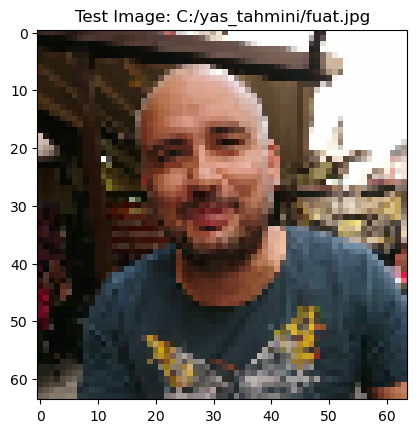

1/1 [==============================] - 0s 24ms/step
Predicted Age: 48, Predicted Gender: Male


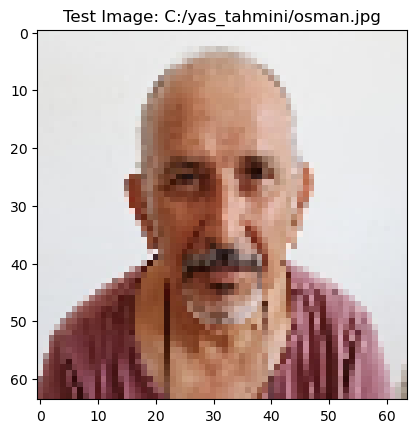

1/1 [==============================] - 0s 23ms/step
Predicted Age: 58, Predicted Gender: Male


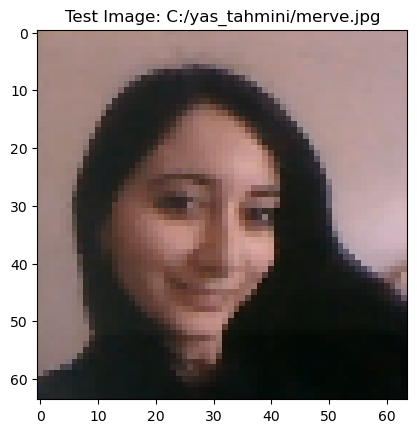

1/1 [==============================] - 0s 20ms/step
Predicted Age: 26, Predicted Gender: Female


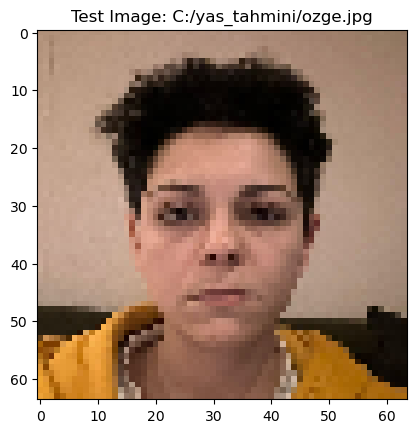

1/1 [==============================] - 0s 19ms/step
Predicted Age: 27, Predicted Gender: Female


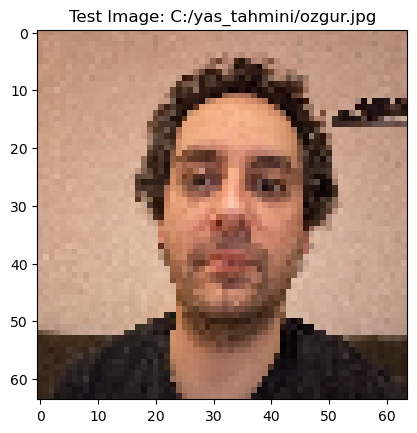

1/1 [==============================] - 0s 23ms/step
Predicted Age: 33, Predicted Gender: Male


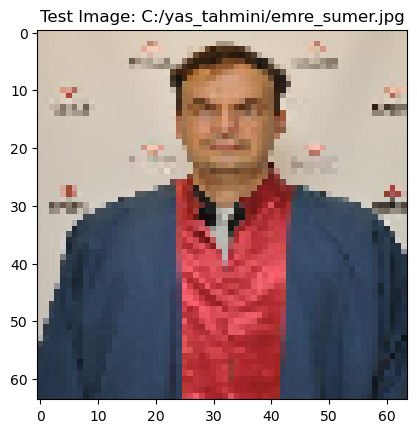

1/1 [==============================] - 0s 19ms/step
Predicted Age: 44, Predicted Gender: Male


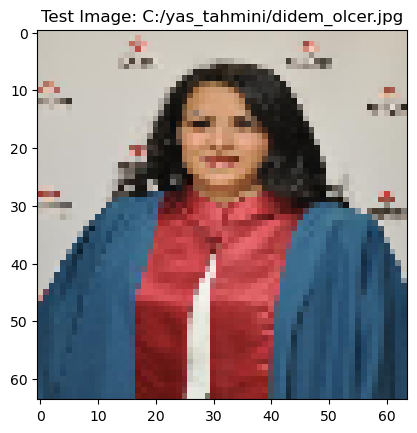

1/1 [==============================] - 0s 22ms/step
Predicted Age: 33, Predicted Gender: Female


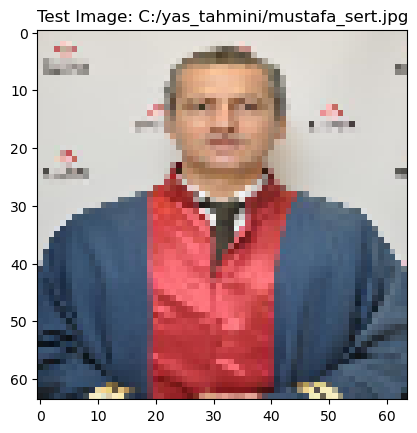

1/1 [==============================] - 0s 22ms/step
Predicted Age: 47, Predicted Gender: Male


In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dropout, Flatten, Dense, MaxPooling2D, Conv2D, Input, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Modeli tanımla
def Konvolusyon(girdi_tensor, filtreler):
    x = Conv2D(filters=filtreler, kernel_size=(3, 3), padding='same', kernel_regularizer=l2(0.01))(girdi_tensor)
    x = Dropout(0.2)(x)
    x = Activation('relu')(x)
    return x

def yas_modeli(input_shape):
    girdiler = Input(input_shape)
    konv_1 = Konvolusyon(girdiler, 32)
    maxp_1 = MaxPooling2D(pool_size=(2, 2))(konv_1)
    konv_2 = Konvolusyon(maxp_1, 32)
    maxp_2 = MaxPooling2D(pool_size=(2, 2))(konv_2)
    duzlestir = Flatten()(maxp_2)
    yoğun_1 = Dense(64, activation='relu')(duzlestir)
    drop_1 = Dropout(0.2)(yoğun_1)
    cikti = Dense(1, activation="relu", name='yas_cikisi')(drop_1)
    model = Model(inputs=[girdiler], outputs=[cikti])
    model.compile(loss=["mae"], optimizer="Adam", metrics=["mae"])
    return model

def cinsiyet_modeli(input_shape):
    girdiler = Input(input_shape)
    konv_1 = Konvolusyon(girdiler, 32)
    maxp_1 = MaxPooling2D(pool_size=(2, 2))(konv_1)
    konv_2 = Konvolusyon(maxp_1, 32)
    maxp_2 = MaxPooling2D(pool_size=(2, 2))(konv_2)
    duzlestir = Flatten()(maxp_2)
    yoğun_1 = Dense(64, activation='relu')(duzlestir)
    drop_1 = Dropout(0.2)(yoğun_1)
    cikti = Dense(1, activation="sigmoid", name='cinsiyet_cikisi')(drop_1)
    model = Model(inputs=[girdiler], outputs=[cikti])
    model.compile(loss=["binary_crossentropy"], optimizer="Adam", metrics=["accuracy"])
    return model

# Modelleri başlat
yas_model = yas_modeli((64, 64, 3))
cinsiyet_model = cinsiyet_modeli((64, 64, 3))

# Önceden eğitilmiş ağırlıkları yükle
yas_model.load_weights('C:/Users/kasim.sahin/age_model_weight644.h5')
cinsiyet_model.load_weights('C:/Users/kasim.sahin/gender_model_weight644.h5')

# Resim tahmini fonksiyonunu tanımla
def external_test_image(image_path, age_model, gender_model):
    # Resmi yükle ve boyutunu ayarla
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (64, 64))

    # Resmi göster
    plt.imshow(image)
    plt.title(f"Test Image: {image_path}")
    plt.show()

    # Normalize et ve tahmin yap
    image = image / 255.0
    age_pred = age_model.predict(np.array([image]))
    gender_pred = gender_model.predict(np.array([image]))

    # Tahminleri düzgün bir şekilde al ve yazdır
    predicted_age = int(np.round(age_pred[0]))  # Yaş tahmini
    predicted_gender = 'Female' if int(np.round(gender_pred[0])) == 1 else 'Male'  # Cinsiyet tahmini

    print(f"Predicted Age: {predicted_age}, Predicted Gender: {predicted_gender}")

# Dışarıdan bir resim dosyası ile test et
external_test_image_path = 'C:/yas_tahmini/kasim.jpg'  # Resmin yolu
external_test_image(external_test_image_path, yas_model, cinsiyet_model)

external_test_image_path = 'C:/yas_tahmini/ali_ihsan.jpg'  # Resmin yolu
external_test_image(external_test_image_path, yas_model, cinsiyet_model)

external_test_image_path = 'C:/yas_tahmini/serdar.jpg'  # Resmin yolu
external_test_image(external_test_image_path, yas_model, cinsiyet_model)

external_test_image_path = 'C:/yas_tahmini/kasim2.jpg'  # Resmin yolu
external_test_image(external_test_image_path, yas_model, cinsiyet_model)

external_test_image_path = 'C:/yas_tahmini/kasim3.jpg'  # Resmin yolu
external_test_image(external_test_image_path, yas_model, cinsiyet_model)

external_test_image_path = 'C:/yas_tahmini/kasim4.jpg'  # Resmin yolu
external_test_image(external_test_image_path, yas_model, cinsiyet_model)

external_test_image_path = 'C:/yas_tahmini/kasim5.jpg'  # Resmin yolu
external_test_image(external_test_image_path, yas_model, cinsiyet_model)

external_test_image_path = 'C:/yas_tahmini/kasim6.jpg'  # Resmin yolu
external_test_image(external_test_image_path, yas_model, cinsiyet_model)

external_test_image_path = 'C:/yas_tahmini/kasim9.jpg'  # Resmin yolu
external_test_image(external_test_image_path, yas_model, cinsiyet_model)

external_test_image_path = 'C:/yas_tahmini/ali_ihsan2.jpg'  # Resmin yolu
external_test_image(external_test_image_path, yas_model, cinsiyet_model)

external_test_image_path = 'C:/yas_tahmini/fuat.jpg'  # Resmin yolu
external_test_image(external_test_image_path, yas_model, cinsiyet_model)

external_test_image_path = 'C:/yas_tahmini/osman.jpg'  # Resmin yolu
external_test_image(external_test_image_path, yas_model, cinsiyet_model)

external_test_image_path = 'C:/yas_tahmini/merve.jpg'  # Resmin yolu
external_test_image(external_test_image_path, yas_model, cinsiyet_model)

external_test_image_path = 'C:/yas_tahmini/ozge.jpg'  # Resmin yolu
external_test_image(external_test_image_path, yas_model, cinsiyet_model)

external_test_image_path = 'C:/yas_tahmini/ozgur.jpg'  # Resmin yolu
external_test_image(external_test_image_path, yas_model, cinsiyet_model)

external_test_image_path = 'C:/yas_tahmini/emre_sumer.jpg'  # Resmin yolu
external_test_image(external_test_image_path, yas_model, cinsiyet_model)

external_test_image_path = 'C:/yas_tahmini/didem_olcer.jpg'  # Resmin yolu
external_test_image(external_test_image_path, yas_model, cinsiyet_model)

external_test_image_path = 'C:/yas_tahmini/mustafa_sert.jpg'  # Resmin yolu
external_test_image(external_test_image_path, yas_model, cinsiyet_model)